In [259]:
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

In [260]:
caracteristiques = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a', sep=';')
lieux = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/2ad65965-36a1-4452-9c08-61a6c874e3e6', sep=';')
vehicules = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667', sep=';')
usagers = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028', sep=';')

# Fusion des bases

In [261]:
data = (usagers.merge(vehicules, on='id_vehicule', suffixes=(None, '_2'))
               .merge(caracteristiques, on='Num_Acc', suffixes=(None, '_3'))
               .merge(lieux, on='Num_Acc')
               .replace(-1, np.nan))
data.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,...,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,138 306 524,B01,2,2,4,2,2002,0.0,1.0,...,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
1,201900000001,138 306 524,B01,1,1,4,2,1993,5.0,1.0,...,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
2,201900000001,138 306 525,A01,1,1,1,1,1959,0.0,1.0,...,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
3,201900000002,138 306 523,A01,1,1,4,2,1994,0.0,1.0,...,4.0,3,845,2.0,NaN,NaN,1.0,0.0,1.0,70.0
4,201900000003,138 306 520,A01,1,1,1,1,1996,0.0,1.0,...,1.0,10,500,3.0,NaN,NaN,1.0,0.0,1.0,90.0


## Suppression des identifiants et variables avec trop de valeurs manquantes (identifiées dans `merge-exploration.ipynb`)

On supprime tous les identifiants, sauf celui des usagers (plus l'année, qui est la même pour tous les accidents de la base)

In [262]:
data.drop(inplace=True, columns=['Num_Acc', 'id_vehicule', 'num_veh', 'Num_Acc_2', 'num_veh_2', 'an'])

On supprime également les variables avec trop de valeurs manquantes

In [263]:
data.drop(inplace=True, columns=['lartpc', 'larrout', 'occutc','v2' ,'v1' ,'voie' ,'adr', 'trajet', 'secu2', 'secu3', 'locp', 'actp', 'etatp'])

In [264]:
data.isna().sum().sort_values(ascending=False)

circ       6726
vma        1899
vosp       1430
nbv        1406
motor       370
situ        227
infra        99
obsm         89
secu1        88
choc         49
manv         46
senc         46
obs          43
surf         40
prof         31
plan         16
col           2
atm           1
lat           0
pr1           0
pr            0
catr          0
long          0
place         0
int           0
agg           0
catu          0
dep           0
lum           0
hrmn          0
mois          0
jour          0
catv          0
an_nais       0
sexe          0
grav          0
com           0
dtype: int64

<AxesSubplot:>

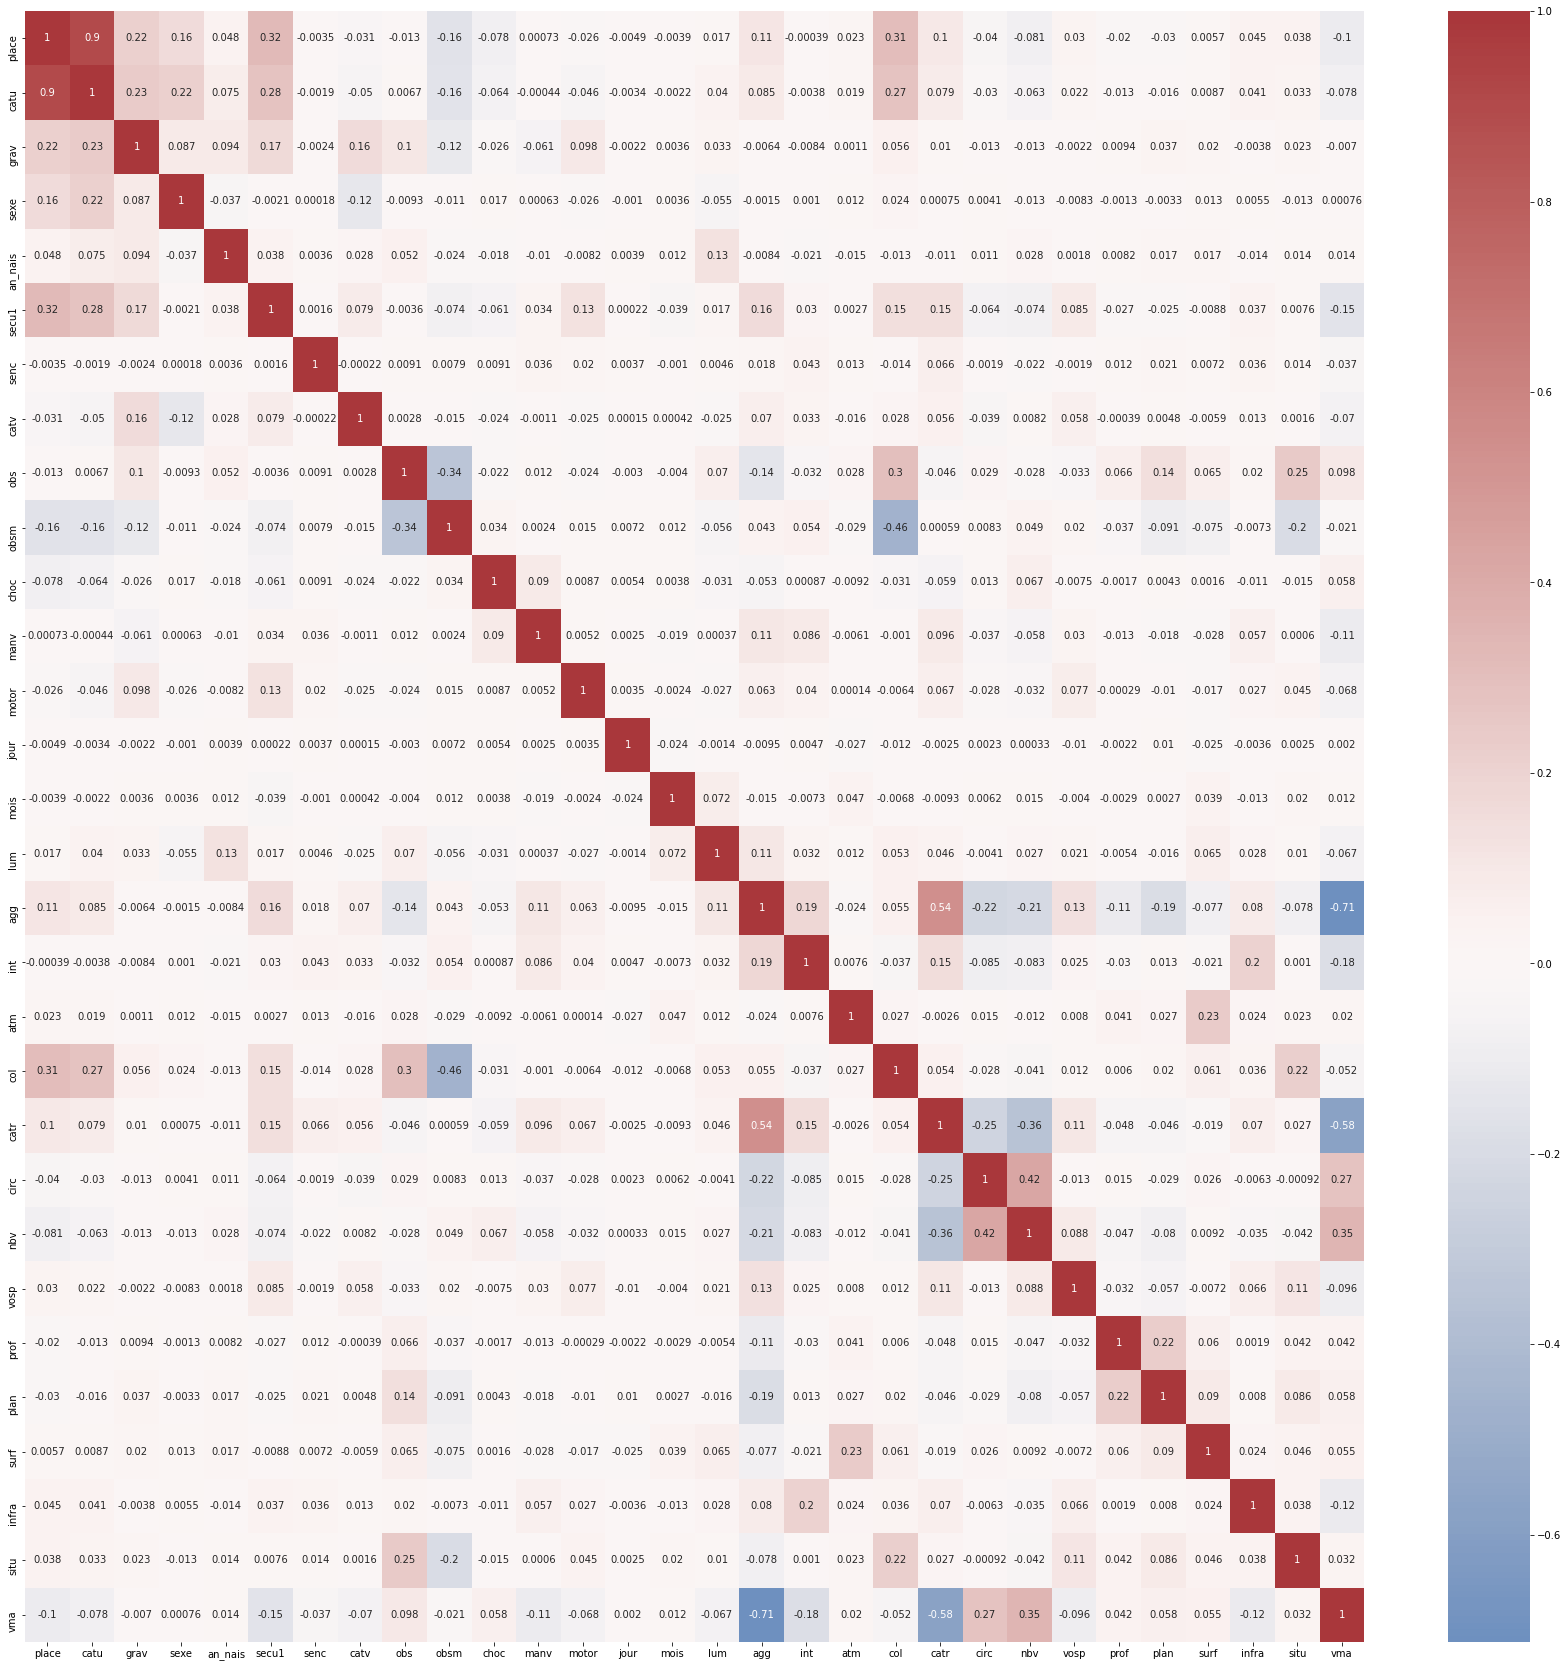

In [265]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(data=corr, annot=corr, cmap='vlag', center=0)

# Transformation des variables

## Variables catégorielles

On transforme les variables catégorielles en suite d'indicatrices :

In [266]:
categories = {
    'place': ['Avant gauche', 'Avant droite', "Passager arrière (à droite)", "Passager arrière (à gauche)", "Passager arrière (au milieu)", "Passager avant (au milieu)", "Passager central (à gauche)", "passager central (au mileu)", "Passager central (à droite)"],
    'catu': ['Conducteur', 'Passager', 'Piéton'],
    'grav': ['Indemne', 'Tué', 'Blessé hospitalisé', 'Blessé léger'],
    'sexe': ['Homme', 'Femme'],
    'secu1': ['Ceinture', 'Casque', 'Dispositif enfant', 'Gilet réflechissant', 'Airbag', 'Gants', 'Gants + Airbag'], # Il va falloir gérer le cas Gants+Airbag à la main
    'senc': ['Croissant', 'Décroissant'], #Pertinence ?
    'catv': ['Bicyclette', 'Cyclomoteur <50cm3', 'Voiturette', '_', '_', '_', 'VL seul', '_', '_', 'VU seul', '_', '_', 'PL seul entre 3,5T et 7,5T', 'PL seul > 7,5T', 'PL > 3,5T avec remorque', 'Tracteur routier seul', 'Tracteur routier + semi-remorque', '_', '_', 'Engin spécial', 'Tracteur agricole'] + 8*['_'] + ['Scooteur >50cm3', 'Motocyclette entre 50 et 125cm3', 'Scooter entre 50 et 125cm3', 'Motocyclette >125cm3', 'Scooter >125cm3', 'Quad léger', 'Quad lourd', 'Autobus', 'Autocar', 'Train', 'Tramway', '3RM <=50cm3', '3RM entre 50 et 125cm3', '3RM >125cm3'] + 6*['_'] + ['EPD à moteur'] + 9*['_'] + ['EPD sans moteur'] + 19*['_'] + ['VAE'],
    'obs': ['Obstacle : '+ obs for obs in ['Véhicule en stationnement', 'Arbre', 'Glissière métallique', 'Glissière béton', 'Autre glissière', 'Bâtiment, mur, pile de pont', 'Support de signalisation vertical ou poste d\'appel d\'urgence', 'Poteau', 'Mobilier urbain', 'Parapet', 'Ilot, refuge, borne haute', 'Bordure de trottoir', 'Fossé, talus, paroi rocheuse', 'Autre obstacle fixe sur chaussée', 'Autre obstacle fixe hors chaussée', "Pas d'obstacle", "Buse, tête d'aqueduc"]],
    'obsm': ["Piéton", "Véhicule", "Véhicule sur rail", "Animal domestique", "Animal sauvage", "Autre obstacle mobile"],
    'choc': ["Choc à l'avant", "Choc à l'avant droit", "Choc à l'avant gauche", "Choc à l'arrière", "Choc à l'arrère droit", "Choc à l'arrière gauche", "Choc côté droit", "Choc côté gauche", "Chocs multiples"],
    'manv': ["Sans changement de direction", "Même sens, même file", "Entre 2 files", "En marche érrière", "À contresens", "En franchissant le terre-plein", "Dans le couloir bus, même sens", "Dans le couloir bus, sens inverse", "En s'insérant", "En faisant demi-tour sur la chaussée", "En changeant de file à gauche", "En changeant de file à droite", "En se déportant à gauche", "En se déportant à droite", "En tournant à gauche", "En tournant à droite", "En dépassant à gauche", "En dépassant à droite", "En traversant la chaussée", "Pendant une manoeuvre de stationnement", "Pendant une manoeuvre d'évitement", "Pendant l'ouverture d'une porte", "À l'arrêt", "En stationnement", "Circulant sur le trottoir", "Autre manoeuvre"],
    'motor': ["Moteur à hydrocarbures", "Moteur hybride", "Moteur électrique", "Moteur à hydrogène", "Propulsion humaine", "Autre propulsion"],
    'lum': ["Plein jour", "Crépuscule ou aube", "Nuit sans éclairage public", "Nuit avec éclairage public éteint", "Nuit avec éclairage public allumé"],
    'agg': ["Hors agglomération", "En agglomération"],
    'int': ["Hors intersection", "Intersection en X", "Intersection en T", "Intersection en Y", "Intersection à plus de 4 branches", "Giratoire", "Place", "Passage à niveau", "Autre intersection"],
    'atm': ["Conditions atmosphériques normales", "Pluie légère", "Pluie forte", "Neige ou grêle", "Brouillard ou fumée", "Vent fort ou tempête", "Temps éblouissant", "Temps couvert", "Autres conditions atmosphériques"],
    'col': ["Collision frontale (2 véhicules)", "Collision par l'arrière (2 véhicules)", "Collision par le côté (2 véhicules)", "Collision en chaîne (3 véhicules ou plus)", "Collisions multiples (3 véhicules ou plus)", "Autre collision", "Sans collision"],
    'catr': ["Autoroute", "Route nationale", "Route départementale", "Voie communale", "Hors réseau public", "Parc de stationnement", "Routes de métropole urbaine", "Autre route"],
    'circ': ["Circulation à sens unique", "Circulation bidirectionnelle", "Circulation à chaussées séparées", "Circulation avec voies d'affectation variables"],
    'vosp': ["Présence d'une piste cyclable", "Présence d'une bande cyclable", "Présence d'une voie réservée"],
    'prof': ["Route plate", "Route en pente", "Sommet de côte", "Bas de côte"],
    'plan': ["En ligne droite", "En courbe à gauche", "En courbe à droite", "En 'S'"],
    'surf': ["Surface normale", "Surface mouillée", "Présence de flaques", "Chaussée inondée", "Chaussée enneigée", "Chaussée boueuse", "Chaussé verglacée", "Présence d'un corps gras sur la chaussée (huile...)", "Autre état de la chaussée"],
    'infra': ["Souterrain, tunnel", "Pont, autopont", "Bretelle d'échangeur ou de raccordement", "Voie ferrée", "Carrefour aménagé", "Zone piétonne", "Zone de péage", "Chantier", "Autre type d'infrastructure"],
    'situ': ["Sur chaussée", "Sur bande d'arrêt d'urgence", "Sur accotement", "Sur trottoir", "Sur piste cyclable", "Sur autre voie spéciale", "Autre lieu"]
}

In [267]:
for var, labels in categories.items():
    for i, label in enumerate(labels):
        if label != '_':
            data[label] = (data[var]==i+1).astype(int)
    data.drop(inplace=True, columns=[var])
data['Gants'] = data['Gants + Airbag']
data['Airbag'] = data['Gants + Airbag']
data.drop(inplace=True, columns=['Gants + Airbag'])
data.head()

,an_nais,jour,mois,hrmn,dep,com,lat,long,nbv,pr,...,Zone de péage,Chantier,Autre type d'infrastructure,Sur chaussée,Sur bande d'arrêt d'urgence,Sur accotement,Sur trottoir,Sur piste cyclable,Sur autre voie spéciale,Autre lieu
0,2002,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,1,0,0,0,0,0,0
1,1993,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,1,0,0,0,0,0,0
2,1959,30,11,01:30,93,93053,"48,8962100","2,4701200",10.0,6,...,0,0,0,1,0,0,0,0,0,0
3,1994,30,11,02:50,93,93066,"48,9307000","2,3688000",2.0,3,...,0,0,0,1,0,0,0,0,0,0
4,1996,28,11,15:15,92,92036,"48,9358718","2,3191744",8.0,10,...,0,0,0,1,0,0,0,0,0,0


Il faut encore gérer les variables non-catégorielles : `an_nais`, `jour`, `mois`, `hrmn`, `dep`, `com`, `lat`, `long`, `nbv`, `pr`, `pr1` et `vma`

## Variables non-catégorielles

### Jour, mois, heure et minute

In [268]:
data['heure'] = data.hrmn.str[:2].astype(int)
data['minute'] = data.hrmn.str[3:].astype(int)
data.drop(inplace=True, columns='hrmn')

<AxesSubplot:>

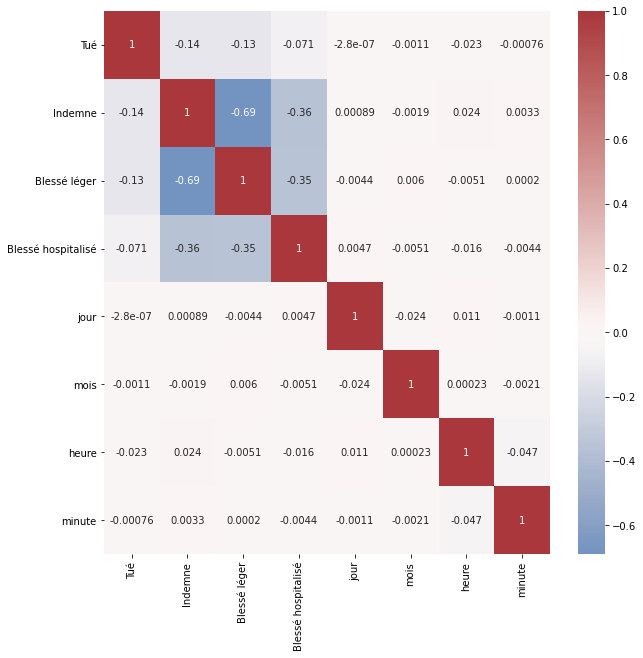

In [269]:
corr = data[['Tué', 'Indemne', 'Blessé léger', 'Blessé hospitalisé', 'jour', 'mois', 'heure', 'minute']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, annot=corr, cmap='vlag', center=0)

`jour`, `mois` et `minute` ont une corrélation très faible (<.01) avec les variables d'intérêt. On peut donc les exclure de l'analyse.

(`heure` aussi dans une moindre mesure, mais je ne sais pas vraiment où placer la limite)

In [270]:
data.drop(inplace=True, columns=['jour', 'mois', 'minute'])

### Vitesse maximale autorisée (`vma`)

On élimine les valeurs erronées pour la vitesse (cf `stats-descriptives.ipynb`, cellule 9) :

In [271]:
na_values = [-1,0,1,2,3,4,6,7,12,500,600,700,800,5,10,42,560]
print(data.shape)
data = data[~data.vma.isin(na_values)]
print(data.shape)

(132977, 208)
(132537, 208)


(Cela n'a supprimé que 39 observations soit moins de 0,03% de l'échantillon)

Pour les valeurs restantes, on fabrique des indicatrices :

In [272]:
for lim in data.vma.unique().tolist():
    data[f'Vitesse limitée à {lim}km/h'] = (data.vma==lim).astype(int)
data.drop(inplace=True, columns='vma')

### Année de naissance

In [273]:
data.an_nais.nunique()

104

Ca rajouterait beaucoup de variables de la transformer en suite d'indicatrices...

### Localisation (`dep`, `com`, `long`, `lat`)

Ces variables sont-elles vraiment explicatives de l'issue de l'accident ?

In [274]:
data['lat'] = data.lat.str.replace(',','.').astype(float)
data['long'] = data.long.str.replace(',','.').astype(float)

<AxesSubplot:>

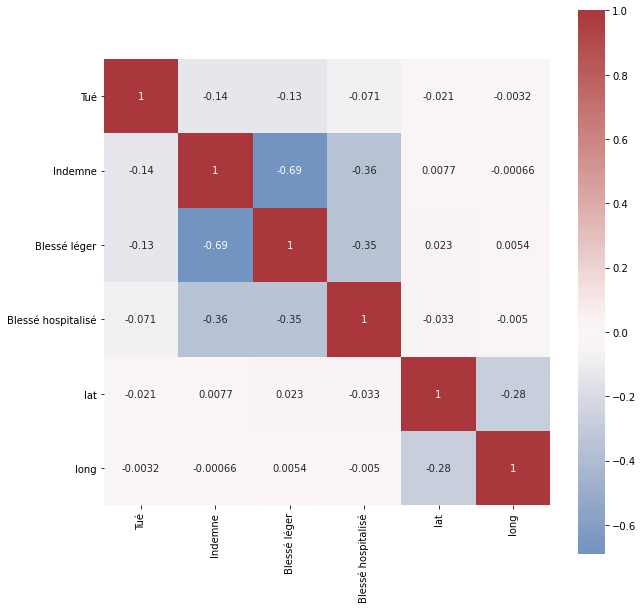

In [275]:
corr = data[['Tué', 'Indemne', 'Blessé léger', 'Blessé hospitalisé', 'lat', 'long']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, annot=corr, cmap='vlag', center=0, square=True)

(Il est impossible de calculer la corrélation pour `com` et `dep` car on en peut pas les transformer en variables numériques. J'avoue que je ne sais pas quoi faire de ces variables du coup. Les transformer en indicatrices me sembre une très mauvaise idée compte tenu du nombre de communes...)

Là aussi, correlation très faible avec les variables d'intérêt. Est-ce que ça vaut le coup de les garder ? À titre de comparaison, les corrélations avec le port de la ceinture et le fait que l'accident ait eu lieu en agglomération :

<AxesSubplot:>

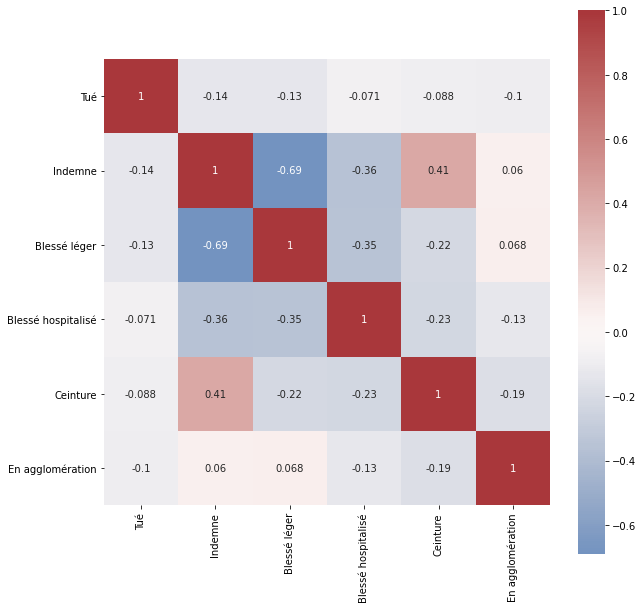

In [276]:
corr = data[['Tué', 'Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Ceinture', 'En agglomération']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, annot=corr, cmap='vlag', center=0, square=True)

### Nombre de voies (`nbv`)

In [278]:
for number in range(1,13):
    data[f'{number} voies de circulation'] = (data.nbv==number).astype(int)
data.drop(inplace=True, columns='nbv')

### Numéro et distance de la borne amont (`pr` et `pr1`)

Ce serait intéressant d'analyser cette variable si on se limitait à une route en particulier, pour repérer les foyers d'accidents, mais dans la mesure où on utilise toute la base de données, je ne sais pas si elle est vraiment pertinente.